Importing necessary libs

In [1]:
import pandas as pd
import tensorflow
import numpy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

I ran this code on Google Colab with mounted Drive so specify path of dataset if running on local. If using Kaggle specify kaggle library.

This Dataset is of a server log for week1 and classifies sessions as suspicious or not. We are trying to see what factors are responsible for malicious activities. I have done some basic preprocessing steps followed by EDA.

In [2]:
df = pd.read_csv("../input/server-logs-suspicious/CIDDS-001-external-week1.csv")

In [3]:
df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,.AP...,0,normal,---,---,---
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,.AP...,0,normal,---,---,---
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,.AP...,0,normal,---,---,---
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,1,.AP...,0,normal,---,---,---
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,1,.AP.S.,0,normal,---,---,---


In [4]:
df.columns

Index(['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt',
       'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos',
       'class', 'attackType', 'attackID', 'attackDescription'],
      dtype='object')

Checking for NULL values below. Some classification models on sklearn do not work well with missing values therefore it is necessary to remove or impute them with another well fitted statistical measure

In [5]:
df.isnull().sum()

Date first seen      0
Duration             0
Proto                0
Src IP Addr          0
Src Pt               0
Dst IP Addr          0
Dst Pt               0
Packets              0
Bytes                0
Flows                0
Flags                0
Tos                  0
class                0
attackType           0
attackID             0
attackDescription    0
dtype: int64

In [6]:
df.dtypes

Date first seen       object
Duration             float64
Proto                 object
Src IP Addr           object
Src Pt                 int64
Dst IP Addr           object
Dst Pt               float64
Packets                int64
Bytes                 object
Flows                  int64
Flags                 object
Tos                    int64
class                 object
attackType            object
attackID              object
attackDescription     object
dtype: object

We have the class variable which we need to predict later on. It has following unique values.

In [7]:
df["class"].unique()

array(['normal', 'suspicious', 'unknown'], dtype=object)

In [8]:
data = df.copy()
data.shape


(172838, 16)

We are using seaborn plots to visualize our data

We can see that majority of the data is suspicious sessions so our model will learn better on classifiying suspicious class.

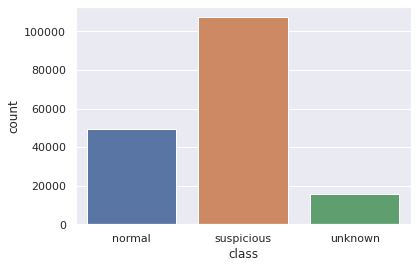

In [9]:
sns.set(style = "darkgrid")
sns.countplot(x = "class",data=data)

The Flags field is a string of some flag variables which are necessary in the networking field. Wherever a certain flag is not set a "." is used. We need to break this columns into individual variables for flags as it will help the model learn faster and establish better relations. 

In [10]:
df["Flags"].unique()

array(['.AP...', '.AP.S.', '....S.', '.A.R..', '.APRS.', '.APRSF',
       '.AP.SF', '......', '  0xdb', '...RS.', '.A..S.', '.A..SF',
       '.A.RS.', '.A.RSF', '...R..', '.A....', '  0xd2', '.A.R.F',
       '  0xc2', '  0xda', '  0xd7', '  0x53', '  0xdf', '  0xd6',
       '  0xd3'], dtype=object)

In [11]:
df["A"]=0
df["P"]=0
df["S"]=0
df["R"]=0
df["F"]=0
df["x"]=0

In [12]:
def set_flag(data,check):
    val=0;
    if(check in list(data["Flags"])):
        val = 1 ;
    return val;

In [13]:
df.columns

Index(['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt',
       'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos',
       'class', 'attackType', 'attackID', 'attackDescription', 'A', 'P', 'S',
       'R', 'F', 'x'],
      dtype='object')

In [14]:
df["A"] = df.apply(set_flag,check ="A", axis = 1)
df["P"] = df.apply(set_flag,check = "P" ,axis = 1)
df["S"] = df.apply(set_flag,check ="S",axis = 1)
df["R"] = df.apply(set_flag,check="R" ,axis = 1)
df["F"] = df.apply(set_flag,check ="F" ,axis = 1)
df["x"] = df.apply(set_flag,check ="x" ,axis = 1)

Checking here the individual flag variables and impact of each variable on class. You can change the variable name in the below plot and see the impact.

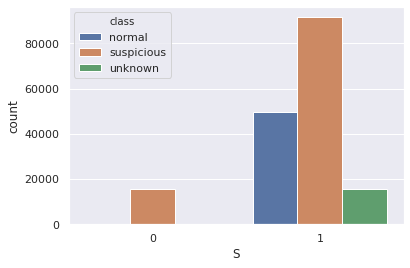

In [15]:
sns.countplot(x="S",hue = "class",data=df)

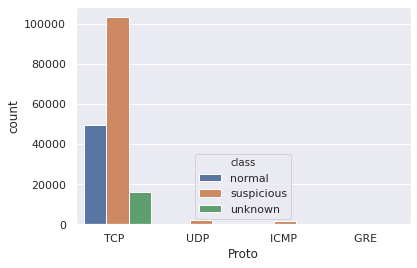

In [16]:
sns.countplot(x = "Proto",hue = "class",data = df)

Dropping some unnecessary columns and columns having a single value like flows and tos

In [17]:
df=df.drop(columns = ["Date first seen","attackType","attackID","attackDescription","Flows","Tos","Flags"])

In [18]:
df.head()

,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,class,A,P,S,R,F,x
0,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,normal,1,1,0,0,0,0
1,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,normal,1,1,0,0,0,0
2,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,normal,1,1,0,0,0,0
3,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,normal,1,1,0,0,0,0
4,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,normal,1,1,1,0,0,0


The Bytes variable was an object as seen in head command and the model would not recognize it as a number. Therefore we convert the M in the number to a multiplication of 1M with the number part. This has been simply done using regex

In [19]:
import re
def convtonum(data):
    num1=data["Bytes"]
    if "M" in data["Bytes"]:
        num=re.findall("[0-9.0-9]",data["Bytes"])
        num1 = float("".join(num))*100000
    num1 = float(num1)
    return num1

In [20]:
df["Bytes"] = df.apply(convtonum,axis = 1)

In [21]:
df.head()

,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,class,A,P,S,R,F,x
0,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,210000.0,normal,1,1,0,0,0,0
1,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,250000.0,normal,1,1,0,0,0,0
2,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,910000.0,normal,1,1,0,0,0,0
3,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,1030000.0,normal,1,1,0,0,0,0
4,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,2720000.0,normal,1,1,1,0,0,0


Label Encoding categorical values.

In [22]:
from sklearn.preprocessing import LabelEncoder
col = ["Proto","class","Src IP Addr","Dst IP Addr"]
enc = LabelEncoder()
for col_name in col:
    df[col_name]=enc.fit_transform(df[col_name])


Correlation Heatmap shows how each variable is correlated with class variable which we will try to predict.

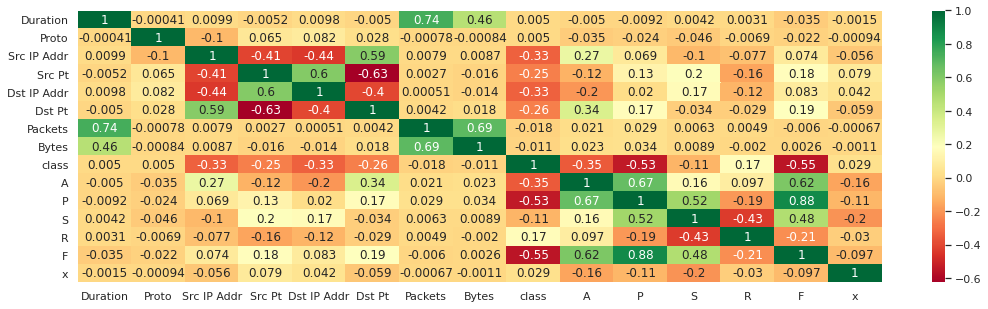

In [23]:
data1 = df.copy()
plt.figure(figsize=(18,5))
sns.heatmap(data1.corr(),annot=True,cmap = "RdYlGn")

In [24]:
data_y = data1["class"]
data_x = data1.drop(columns = ["class"])

Breaking dataset into train and test sets randomly

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=1)

In [26]:
#decision-tree-classifier - single-tree-classifier  // using all features

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=10) # you can use GINI index also here as a critirion 
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

We got a 99% accuracy on the first go we can check further if it is overfitting and also see important variable in the model 

In [27]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.999537144179588


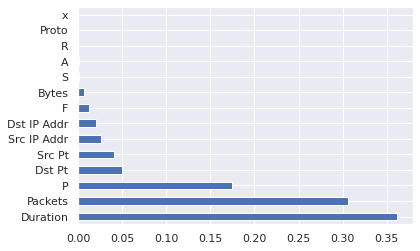

In [28]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [29]:
# if you want to select most important features from an algorithm use recursive feature elimination and run algorithm on that

from sklearn.feature_selection import RFE

m = DecisionTreeClassifier(criterion="entropy", max_depth=10)
rfe = RFE(m,8)
fit=rfe.fit(X_train,y_train)

print(X_train.columns)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Index(['Duration', 'Proto', 'Src IP Addr', 'Src Pt', 'Dst IP Addr', 'Dst Pt',
       'Packets', 'Bytes', 'A', 'P', 'S', 'R', 'F', 'x'],
      dtype='object')
Num Features: 8
Selected Features: [ True False  True  True  True  True  True False False  True False False
  True False]
Feature Ranking: [1 5 1 1 1 1 1 2 6 1 3 4 1 7]


Please upvote the kernel if it was helpful